In [137]:
# preprocessing
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

# modelling
from sklearn.ensemble import RandomForestRegressor

# evaluation
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split



# hyperparameter optimisation
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample

# Hyperparameter Optimisation with `hyperopt` library

This notebook introduces basic hyperoptimisations methods and demonstrates how to use `hyperopt` library using Bayesian Optimisation for hyperparameter tuning.

## Brief intro to hyperparameter tuning

__A hyperparameter__ is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (for example, model weights) are learned.
__Hyperparameter tuning__ is the problem of choosing a set of hyperparameters for a learning algorithm for optimal performance. 

https://playground.tensorflow.org/

<img src="tensorflow_playground.png" alt="TensorflowPlayground" width="900"/>

In [138]:
# Let's look at the simplest example:

x = np.linspace(-1, 1, 15)
print(x)

def polynomial_y(x):
    noise = np.random.normal(1, 20, x.shape)
    y = 5*x + 3*x**2 + 11*x**3 + 2*x**4 + 4*x**5 + noise
    return(y)

y = polynomial_y(x)

[-1.         -0.85714286 -0.71428571 -0.57142857 -0.42857143 -0.28571429
 -0.14285714  0.          0.14285714  0.28571429  0.42857143  0.57142857
  0.71428571  0.85714286  1.        ]


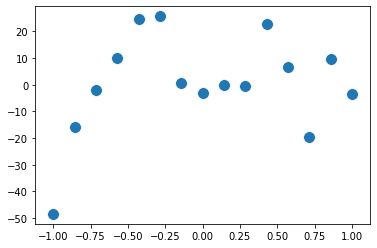

In [139]:
sns.scatterplot(x, y, s=140)

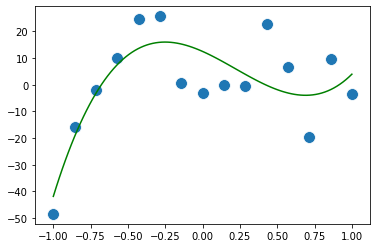

In [142]:
from numpy.polynomial import Polynomial

hyperparam = 3 # try other hyperparameters
p = Polynomial.fit(x, y, hyperparam)

sns.scatterplot(x, y, s=140)
plt.plot(*p.linspace(), color='green')


In [53]:
print("Congratulations! You manually tuned one hyperparameter! {}".format(emoji.emojize(":party_popper:")*3))

Congratulations! You manually tuned one hyperparameter! 🎉🎉🎉


Hyperparameter tuning is very experimental, which means that in order to find the optimal settings you have to try many different combinations of hyperparameters. With the increase of hyperparameters, the search space increases drastically. 

## Most common optimisation techniques

* __Grid search__: In this approach you have to specify a grid of hyperparameter values, train a model for each of the combinations, and evaluate. It is quite inefficient approach. 
* __Random search__: One of the most common ways to proceed is to optimise the model using hyperparameters' random search. At each step you assign hyperparameters' values randomly within a specified grid.
* __Bayesian search__: It is a guided search for the best hyperparameters  within a specified grid of hyperparameters. 

<img src="sig_opt_comparison.png" alt="OptimisationTechniques" width="900"/>

Grid search, random search, and Bayesian optimization 
<sup>Photo credit: [Sigopt](https://sigopt.com/blog/common-problems-in-hyperparameter-optimization)</sup>

In [143]:
# Let's create a toy example:

X_train = np.random.normal(loc=1.0, size = 1000)
y_train = polynomial_y(X_train)

X_test = np.random.normal(loc=1.0, size = 300)
y_test = polynomial_y(X_test)

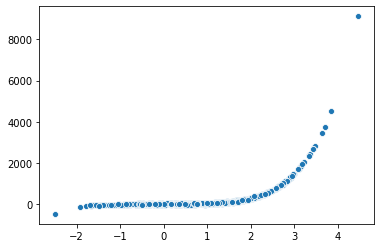

In [144]:
sns.scatterplot(X_train, y_train)

In [145]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [146]:
rf = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [147]:
rmse = np.sqrt(np.mean(np.square(rf_preds - y_test)))
rmse 

93.9169679797053

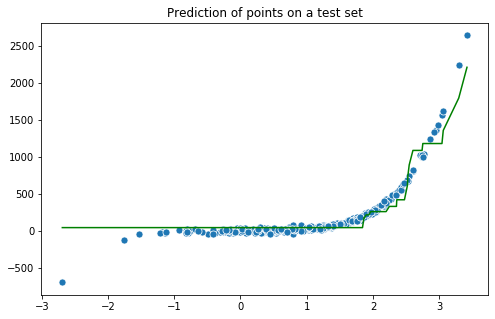

In [148]:
plt.figure(figsize=(8,5))
plt.title("Prediction of points on a test set")
sns.scatterplot(X_test.flatten(), y_test, s=50)
sns.lineplot(X_test.flatten(), rf_preds, color='green')

In [149]:
# Hyperparameter grid

random_param_grid = {
    'n_estimators': list(range(10, 100, 10)),
    'max_depth': list(range(1, 10, 1)),
    'min_samples_leaf': [1, 2, 3, 4]
}

In [150]:
com = 1
for x in random_param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 324 combinations


In [151]:
print(random_param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 2, 3, 4]}


In [152]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_param_grid, n_iter = 50, cv = 5, verbose=1, random_state=42)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [153]:
rf_random.best_params_

{'n_estimators': 70, 'min_samples_leaf': 1, 'max_depth': 8}

In [154]:
best_random = rf_random.best_estimator_
rf_preds_best = best_random.predict(X_test)
rmse = np.sqrt(np.mean(np.square(rf_preds_best - y_test)))
rmse 

29.508045026114395

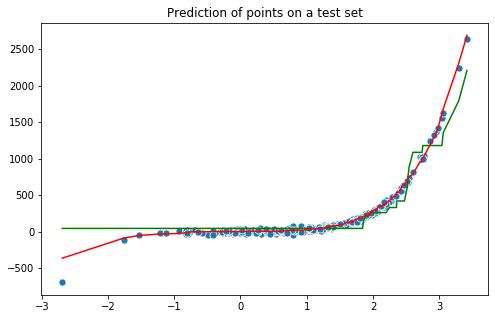

In [155]:
plt.figure(figsize=(8,5))
plt.title("Prediction of points on a test set")
sns.scatterplot(X_test.flatten(), y_test, s=50)
sns.lineplot(X_test.flatten(), rf_preds, color='green')
sns.lineplot(X_test.flatten(), rf_preds_best, color='red')

## What is Bayesian Optimisation and how it differs from other optimisation techniques?

> build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

<img src="https://miro.medium.com/max/2802/1*NT0OUPK1EyliETxy5KRemA.gif" alt="BayesianExplained" width="600"/>

<sub>Bayesian optimization in action using expected improvement as acquisition function [6]</sub>

There are five aspects of model-based hyperparameter optimization:
1. Hyperparameters domain for a search
2. An objective function with hyperparameters as an input and a score function we want to minimse/maximise as an output
3. The surrogate model of the objective function (Most common choises: Gaussian Processes, Random Forest Regressions, Tree Parzen Estimators (TPE))
4. A criteria, called a selection function, for evaluating which hyperparameters to choose next from the surrogate model (Most common: Expected Improvement, $EI(x) = E[max(0, f(x) - f(x*))]$)
5. A history consisting of (score, hyperparameter) pairs used by the algorithm to update the surrogate model
<sub>[1]</sub>
   

> `hyperopt` (http://jaberg.github.io/hyperopt/) - is a Python library for optimizing over awkward search spaces with real-valued, discrete, and conditional dimensions. Uses TPE for a surrogate model and Expected Improvement as a selection function

In [158]:
#<img src="parzen_window.gif" alt="PTE" width="600"/>

## How to use `hyperopt`

#### The simplest case:

In [117]:
import time


def objective(x):
    return {
        'loss': x ** 2,
        'status': STATUS_OK,
        'eval_time': time.time(), # we can store whatever we want here
        }
trials = Trials()
best = fmin(objective,
    space = hp.uniform('x', -10, 10),
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials)

print(best)

100%|██████████| 100/100 [00:00<00:00, 489.47it/s, best loss: 0.0020699197534867304]
{'x': -0.04549637077269714}


In [156]:
#trials.trials
#trials.results
#trials.losses()

#### 1. Hyperparameters domain for a search

For prevous methods we used a grid of hyperparameters, now we will have to define probability distributions:

In [118]:
# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 10), # Returns a value like round(uniform(low, high) / q) * q
    'max_depth': 1 + hp.qlognormal('max_depth', 2, 1, 1), # hp.qlognormal(label, mu, sigma, q) Returns a value like round(exp(normal(mu, sigma)) / q) * q
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 5, 8, 10])
}

In [119]:
example = sample(space)
example

{'max_depth': 25.0, 'min_samples_leaf': 10, 'n_estimators': 60.0}

In [120]:
example_dists = []
for i in range(50):
    example = sample(space)
    example_dists.append(example)  

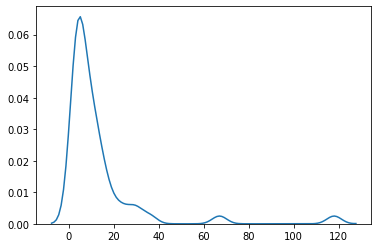

In [121]:
max_depth_dist = [d['max_depth'] for d in example_dists]
sns.kdeplot(max_depth_dist)

#### 2. An objective function

In [122]:
def objective(hyperparameters):
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # the model expects integers:
    for parameter_name in ['n_estimators', 'min_samples_leaf']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])
    
    # Machine learning model
    rf = RandomForestRegressor(**hyperparameters)
    
    train_set, val_set = train_test_split(
        dt_train, train_size=0.8, test_size=None)
    
    # Training 
    rf.fit(train_set.drop("y", axis=1), train_set["y"])
    
    # Making predictions and evaluating
    predictions = rf.predict(val_set.drop("y", axis=1))
    loss = np.sqrt(np.mean(np.square(predictions - val_set["y"]))) #rmse is a loss
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'status': STATUS_OK}

#### 3. Putting all together

In [123]:
dt_train = pd.DataFrame({"feature_1": X_train.flatten(), "y": y_train})
dt_test = pd.DataFrame({"feature_1": X_test.flatten(), "y": y_test})

In [124]:
# Keep track of results
bayes_trials = Trials()

In [125]:
MAX_EVALS = 50

In [126]:
# %%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 50/50 [00:02<00:00, 17.82it/s, best loss: 21.8916008597146]


In [127]:
best

{'max_depth': 10.0, 'min_samples_leaf': 0, 'n_estimators': 40.0}

In [128]:
# Sort the trials with lowest loss (highest AUC) first
bayes_results = sorted(bayes_trials.results, key = lambda x: x['loss'])

In [129]:
bayes_results[:3]

[{'loss': 21.8916008597146,
  'hyperparameters': {'max_depth': 11.0,
   'min_samples_leaf': 1,
   'n_estimators': 40},
  'iteration': 6,
  'status': 'ok'},
 {'loss': 22.33382134608905,
  'hyperparameters': {'max_depth': 8.0,
   'min_samples_leaf': 5,
   'n_estimators': 70},
  'iteration': 45,
  'status': 'ok'},
 {'loss': 23.95314601197493,
  'hyperparameters': {'max_depth': 10.0,
   'min_samples_leaf': 1,
   'n_estimators': 90},
  'iteration': 30,
  'status': 'ok'}]

In [130]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_params = bayes_results[0]['hyperparameters']

rf = RandomForestRegressor(**best_bayes_params)

#best_bayes_model.fit(features, labels)

In [131]:
rf.fit(dt_train.drop("y", axis=1), dt_train["y"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11.0,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [132]:
bayes_best_preds = rf.predict(dt_test.drop("y", axis=1))
np.sqrt(np.mean(np.square(bayes_best_preds - dt_test["y"])))

21.91478056870472

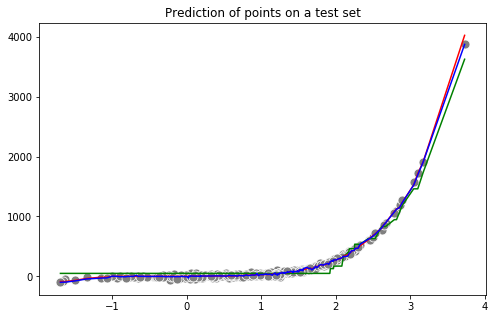

In [136]:
plt.figure(figsize=(8,5))
plt.title("Prediction of points on a test set")
sns.scatterplot(X_test.flatten(), y_test, s=80, color='grey')
sns.lineplot(X_test.flatten(), rf_preds, color='green')
sns.lineplot(X_test.flatten(), rf_preds_best, color='red')
sns.lineplot(X_test.flatten(), bayes_best_preds, color='blue')

References:
    1. https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
    2. https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
    3. https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/tutorials/tut8_adams_slides.pdf
    4. https://link.springer.com/chapter/10.1007/978-3-030-05318-5_1
    5. https://github.com/hyperopt/hyperopt/wiki/FMin
    6. https://medium.com/criteo-labs/hyper-parameter-optimization-algorithms-2fe447525903